In [1]:
import cv2
import os
import random
import torch
import torchvision
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm
from torchvision.models import ResNeXt50_32X4D_Weights
from torch.utils.data import DataLoader
from typing import Iterable

from helpers.datasets import CrackDataset, custom_collate_fn
from helpers.early_stopping import EarlyStopping

In [2]:
class Resnext50RCNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), linear_layers_features=512):
        super(Resnext50RCNN, self).__init__()

        self.feature_extractor = models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._get_feature_size(input_shape), linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, 1)
        )
        self.bbox_regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._get_feature_size(input_shape), linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, linear_layers_features),
            nn.ReLU(inplace=True),
            nn.Linear(linear_layers_features, 4)
        )
        self.roi_size = (input_shape[1], input_shape[2])

    def _get_feature_size(self, shape: tuple):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            features = self.feature_extractor(dummy_input)
            return features.numel()

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        class_scores = self.classifier(x)
        bbox_deltas = self.bbox_regressor(x)
    
        return class_scores, bbox_deltas

    def extract_region_features(self, image: torch.Tensor, boxes: Iterable[torch.Tensor]) -> torch.Tensor:
        """
        For each bounding box, crop the region, resize to the input shape, and pass through the feature extractor.
        """
        regions = []
        image = image.float() / 255.0

        for box in boxes:
            x1, y1, x2, y2 = box.int()
            region = image[:, y1:y2, x1:x2]
            region_resized = nn.functional.interpolate(region.unsqueeze(0), size=self.roi_size, mode="bilinear", align_corners=False)
            
            regions.append(region_resized)

        regions = torch.cat(regions, dim=0)
        features = self.feature_extractor(regions)
        
        return features

    def refine_bboxes(self, proposals: torch.Tensor, deltas: torch.Tensor) -> torch.Tensor:
        """
        Refines the original bounding boxes (proposals) using the predicted bbox deltas.
        Args:
        - proposals: The original bounding boxes from selective search (x1, y1, x2, y2)
        - deltas: Predicted bounding box adjustments (dx, dy, dw, dh)

        Returns:
        - Refined bounding boxes (x1', y1', x2', y2')
        """
        widths = proposals[:, 2] - proposals[:, 0]
        heights = proposals[:, 3] - proposals[:, 1]
        ctr_x = proposals[:, 0] + 0.5 * widths
        ctr_y = proposals[:, 1] + 0.5 * heights
        dx = deltas[:, 0]
        dy = deltas[:, 1]
        dw = deltas[:, 2]
        dh = deltas[:, 3]
        refined_ctr_x = ctr_x + dx * widths
        refined_ctr_y = ctr_y + dy * heights
        refined_widths = widths * torch.exp(dw)
        refined_heights = heights * torch.exp(dh)
        refined_x1 = refined_ctr_x - 0.5 * refined_widths
        refined_y1 = refined_ctr_y - 0.5 * refined_heights
        refined_x2 = refined_ctr_x + 0.5 * refined_widths
        refined_y2 = refined_ctr_y + 0.5 * refined_heights
        refined_boxes = torch.stack([refined_x1, refined_y1, refined_x2, refined_y2], dim=1)
        
        return torch.clamp(refined_boxes, min=0)

    def predict(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        class_scores = self.classifier(features)
        bbox_deltas = self.bbox_regressor(features)
        
        return class_scores, bbox_deltas

In [3]:
def list_image_paths(directory: str) -> list[str]:
    return [os.path.join(directory, file) for file in os.listdir(directory)]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Resnext50RCNN().to(device)
criterion_class = nn.BCEWithLogitsLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_coco_path = os.path.join("data", "train", "coco_annotations.json")
valid_coco_path = os.path.join("data", "valid", "coco_annotations.json")
train_images_dir = os.path.join("data", "train_small", "images")
valid_images_dir = os.path.join("data", "valid_small", "images")
train_dataset = CrackDataset(
    train_coco_path,
    train_images_dir
)
valid_dataset = CrackDataset(
    valid_coco_path,
    valid_images_dir
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=custom_collate_fn
)
valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=custom_collate_fn
)
early_stopping = EarlyStopping(patience=2, verbose=True, delta=0)
num_epochs = 30

In [4]:
def match_proposals_to_ground_truth(
        proposals: torch.Tensor, 
        bboxes: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    if bboxes.size(0) == 0:
        return (torch.empty(0, 4, device=proposals.device), 
                torch.empty(0, 4, device=proposals.device), 
                torch.zeros(proposals.size(0), dtype=torch.bool, device=proposals.device))
    
    ious = torchvision.ops.box_iou(proposals, bboxes)
    max_ious, best_bbox_idx = ious.max(dim=1)
    assigned_labels = max_ious > 0.1
    matched_proposals = proposals[assigned_labels]
    matched_bboxes = bboxes[best_bbox_idx[assigned_labels]]
    
    return matched_proposals, torch.clamp(matched_bboxes, min=0), assigned_labels


proposal_cache = defaultdict(list)


def perform_selective_search(image: np.ndarray, image_path: str, batch_size: int = 70) -> torch.Tensor:
    """
    Perform selective search and return the largest proposals (by area) in three batches after shuffling.
    Cache the proposals based on the image path to avoid redundant computation.
    
    Args:
    - image: The input image as a numpy array.
    - image_path: The file path to the image (used as the cache key).
    - batch_size: The size of each batch (default 50).
    
    Yields:
    - A batch of proposals as a torch.Tensor of shape [batch_size, 4].
    """
    if image_path in proposal_cache:
        for start in range(0, len(proposal_cache[image_path]), batch_size):
            yield torch.tensor(proposal_cache[image_path][start:start + batch_size], dtype=torch.float32).to(device)
    else:
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()

        rects = ss.process()
        boxes = []

        for (x, y, w, h) in rects:
            area = w * h

            boxes.append((x, y, x + w, y + h, area))

        boxes = sorted(boxes, key=lambda b: b[4], reverse=True)
        boxes = [(x1, y1, x2, y2) for x1, y1, x2, y2, area in boxes]
        num_proposals = min(len(boxes), 2 * batch_size)
        top_proposals = boxes[:num_proposals]

        random.shuffle(top_proposals)

        proposal_cache[image_path] = top_proposals

        for start in range(0, num_proposals, batch_size):
            yield torch.tensor(top_proposals[start:start + batch_size], dtype=torch.float32).to(device)

In [5]:
def run_model(image: torch.Tensor, proposals: torch.Tensor, bboxes: list[int], is_test: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
    features = model.extract_region_features(image, proposals)
    class_scores, bbox_deltas = model.predict(features) if is_test else model(features)
    refined_bboxes = model.refine_bboxes(proposals, bbox_deltas)
    bboxes_tensor = torch.tensor(bboxes[i], dtype=torch.float32, device=device)
    matched_proposals, matched_bboxes, assigned_labels = match_proposals_to_ground_truth(proposals, bboxes_tensor)

    torch.cuda.empty_cache()

    cls_loss = criterion_class(class_scores, assigned_labels.float().unsqueeze(1))

    if len(matched_proposals) > 0 and len(refined_bboxes[assigned_labels]) > 0:
        bbox_loss = criterion_bbox(refined_bboxes[assigned_labels], matched_bboxes)
    else:
        bbox_loss = torch.tensor(0.0, device=device)

    return cls_loss, bbox_loss


def save_checkpoint(model, optimizer, epoch, train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses, filepath):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_cls_losses': train_cls_losses,
        'train_bbox_losses': train_bbox_losses,
        'val_cls_losses': val_cls_losses,
        'val_bbox_losses': val_bbox_losses
    }
    torch.save(checkpoint, filepath)


def load_checkpoint(filepath):
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_cls_losses = checkpoint['train_cls_losses']
        train_bbox_losses = checkpoint['train_bbox_losses']
        val_cls_losses = checkpoint['val_cls_losses']
        val_bbox_losses = checkpoint['val_bbox_losses']
        
        print(f"Checkpoint loaded from {filepath}")
        
        return epoch, train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses
    else:
        print(f"No checkpoint found at {filepath}")
        
        return 0, [], [], [], []

In [6]:
checkpoint_path = os.path.join("checkpoints", f"rcnn_with_resnext")
start_epoch, train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses = load_checkpoint(checkpoint_path)

for epoch in range(start_epoch, num_epochs):
    model.train()

    total_cls_loss = 0.0
    total_bbox_loss = 0.0
    epoch_progress = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for image_paths, images, bboxes in epoch_progress:
        images = torch.tensor(np.array(images), dtype=torch.uint8, device=device)

        optimizer.zero_grad()

        for i, image in enumerate(images):
            image_path = image_paths[i]
            prepared_image = image.cpu().permute(1, 2, 0).numpy()

            for proposals in perform_selective_search(prepared_image, image_path=image_path):
                cls_loss, bbox_loss = run_model(image, proposals, bboxes)
                loss = cls_loss + bbox_loss

                loss.backward()
                optimizer.step()

                total_cls_loss += cls_loss.item()
                total_bbox_loss += bbox_loss.item()

        avg_cls_loss = total_cls_loss / len(train_dataloader)
        avg_bbox_loss = total_bbox_loss / len(train_dataloader)

        train_cls_losses.append(avg_cls_loss)
        train_bbox_losses.append(avg_bbox_loss)
        epoch_progress.set_postfix({
            "Cls Loss": f"{avg_cls_loss:.4f}",
            "BBox Loss": f"{avg_bbox_loss:.4f}"
        })

    print(f"Epoch {epoch + 1} completed. Avg Classification Loss: {avg_cls_loss:.4f}, Avg BBox Regression Loss: {avg_bbox_loss:.4f}")
    model.eval()
    
    val_cls_loss = 0.0
    val_bbox_loss = 0.0

    with torch.no_grad():
        for image_paths, images, bboxes in valid_dataloader:
            images = torch.tensor(np.array(images), dtype=torch.uint8, device=device)

            for i, image in enumerate(images):
                image_path = image_paths[i]
                prepared_image = image.cpu().permute(1, 2, 0).numpy()

                for proposals in perform_selective_search(prepared_image, image_path=image_path):
                    cls_loss, bbox_loss = run_model(image, proposals, bboxes)
                    val_cls_loss += cls_loss.item()
                    val_bbox_loss += bbox_loss.item()

    avg_val_cls_loss = val_cls_loss / len(valid_dataloader)
    avg_val_bbox_loss = val_bbox_loss / len(valid_dataloader)
    avg_val_loss = avg_val_cls_loss + avg_val_bbox_loss

    val_cls_losses.append(avg_val_cls_loss)
    val_bbox_losses.append(avg_val_bbox_loss)
    print(f"Validation completed. Avg Validation Classification Loss: {avg_val_cls_loss:.4f}, Avg Validation BBox Regression Loss: {avg_val_bbox_loss:.4f}")
    early_stopping(avg_val_loss, model, f"{checkpoint_path}_{epoch}.pt")

    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

    save_checkpoint(model, optimizer, epoch + 1, train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses, checkpoint_path)

No checkpoint found at checkpoints\rcnn_with_resnext


Epoch 1/30: 100%|██████████| 3/3 [00:31<00:00, 10.60s/batch, Cls Loss=361.0540, BBox Loss=47332569689808024.0000]


Epoch 1 completed. Avg Classification Loss: 361.0540, Avg BBox Regression Loss: 47332569689808024.0000
Validation completed. Avg Validation Classification Loss: 1276464.4062, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (inf --> 1278879.281250).  Saving model ...


Epoch 2/30: 100%|██████████| 3/3 [00:18<00:00,  6.29s/batch, Cls Loss=41.5231, BBox Loss=2240.2917]


Epoch 2 completed. Avg Classification Loss: 41.5231, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 21.2275, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (1278879.281250 --> 2436.102458).  Saving model ...


Epoch 3/30: 100%|██████████| 3/3 [00:22<00:00,  7.54s/batch, Cls Loss=17.4911, BBox Loss=2240.2917]


Epoch 3 completed. Avg Classification Loss: 17.4911, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.9379, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2436.102458 --> 2435.812886).  Saving model ...


Epoch 4/30: 100%|██████████| 3/3 [00:18<00:00,  6.10s/batch, Cls Loss=17.3392, BBox Loss=2240.2917]


Epoch 4 completed. Avg Classification Loss: 17.3392, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.7339, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.812886 --> 2435.608871).  Saving model ...


Epoch 5/30: 100%|██████████| 3/3 [00:18<00:00,  6.16s/batch, Cls Loss=17.2937, BBox Loss=2240.2917]


Epoch 5 completed. Avg Classification Loss: 17.2937, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.5706, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.608871 --> 2435.445601).  Saving model ...


Epoch 6/30: 100%|██████████| 3/3 [00:19<00:00,  6.53s/batch, Cls Loss=17.2321, BBox Loss=2240.2917]


Epoch 6 completed. Avg Classification Loss: 17.2321, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.3925, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.445601 --> 2435.267538).  Saving model ...


Epoch 7/30: 100%|██████████| 3/3 [00:18<00:00,  6.24s/batch, Cls Loss=17.1582, BBox Loss=2240.2917]


Epoch 7 completed. Avg Classification Loss: 17.1582, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.3420, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.267538 --> 2435.216974).  Saving model ...


Epoch 8/30: 100%|██████████| 3/3 [00:18<00:00,  6.28s/batch, Cls Loss=17.1505, BBox Loss=2240.2917]


Epoch 8 completed. Avg Classification Loss: 17.1505, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.3351, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.216974 --> 2435.210079).  Saving model ...


Epoch 9/30: 100%|██████████| 3/3 [00:18<00:00,  6.06s/batch, Cls Loss=17.1679, BBox Loss=2240.2917]


Epoch 9 completed. Avg Classification Loss: 17.1679, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.1128, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2435.210079 --> 2434.987834).  Saving model ...


Epoch 10/30: 100%|██████████| 3/3 [00:18<00:00,  6.13s/batch, Cls Loss=17.1327, BBox Loss=2240.2917]


Epoch 10 completed. Avg Classification Loss: 17.1327, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.2308, Avg Validation BBox Regression Loss: 2414.8750
EarlyStopping counter: 1 out of 2


Epoch 11/30: 100%|██████████| 3/3 [00:17<00:00,  5.99s/batch, Cls Loss=17.1281, BBox Loss=2240.2917]


Epoch 11 completed. Avg Classification Loss: 17.1281, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 20.1061, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2434.987834 --> 2434.981061).  Saving model ...


Epoch 12/30: 100%|██████████| 3/3 [00:18<00:00,  6.15s/batch, Cls Loss=17.0829, BBox Loss=2240.2917]


Epoch 12 completed. Avg Classification Loss: 17.0829, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 19.9837, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2434.981061 --> 2434.858676).  Saving model ...


Epoch 13/30: 100%|██████████| 3/3 [00:18<00:00,  6.17s/batch, Cls Loss=17.1577, BBox Loss=2240.2917]


Epoch 13 completed. Avg Classification Loss: 17.1577, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 19.8225, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2434.858676 --> 2434.697550).  Saving model ...


Epoch 14/30: 100%|██████████| 3/3 [00:18<00:00,  6.02s/batch, Cls Loss=17.1384, BBox Loss=2240.2917]


Epoch 14 completed. Avg Classification Loss: 17.1384, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 19.8001, Avg Validation BBox Regression Loss: 2414.8750
Validation loss decreased (2434.697550 --> 2434.675056).  Saving model ...


Epoch 15/30: 100%|██████████| 3/3 [00:18<00:00,  6.09s/batch, Cls Loss=17.1046, BBox Loss=2240.2917]


Epoch 15 completed. Avg Classification Loss: 17.1046, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 19.8611, Avg Validation BBox Regression Loss: 2414.8750
EarlyStopping counter: 1 out of 2


Epoch 16/30: 100%|██████████| 3/3 [00:18<00:00,  6.12s/batch, Cls Loss=17.0859, BBox Loss=2240.2917]


Epoch 16 completed. Avg Classification Loss: 17.0859, Avg BBox Regression Loss: 2240.2917
Validation completed. Avg Validation Classification Loss: 19.8985, Avg Validation BBox Regression Loss: 2414.8750
EarlyStopping counter: 2 out of 2
Early stopping triggered. Stopping training.


C:\Users\mmale\AppData\Local\Temp\ipykernel_13292\2216436514.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
Clipping 

[[[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


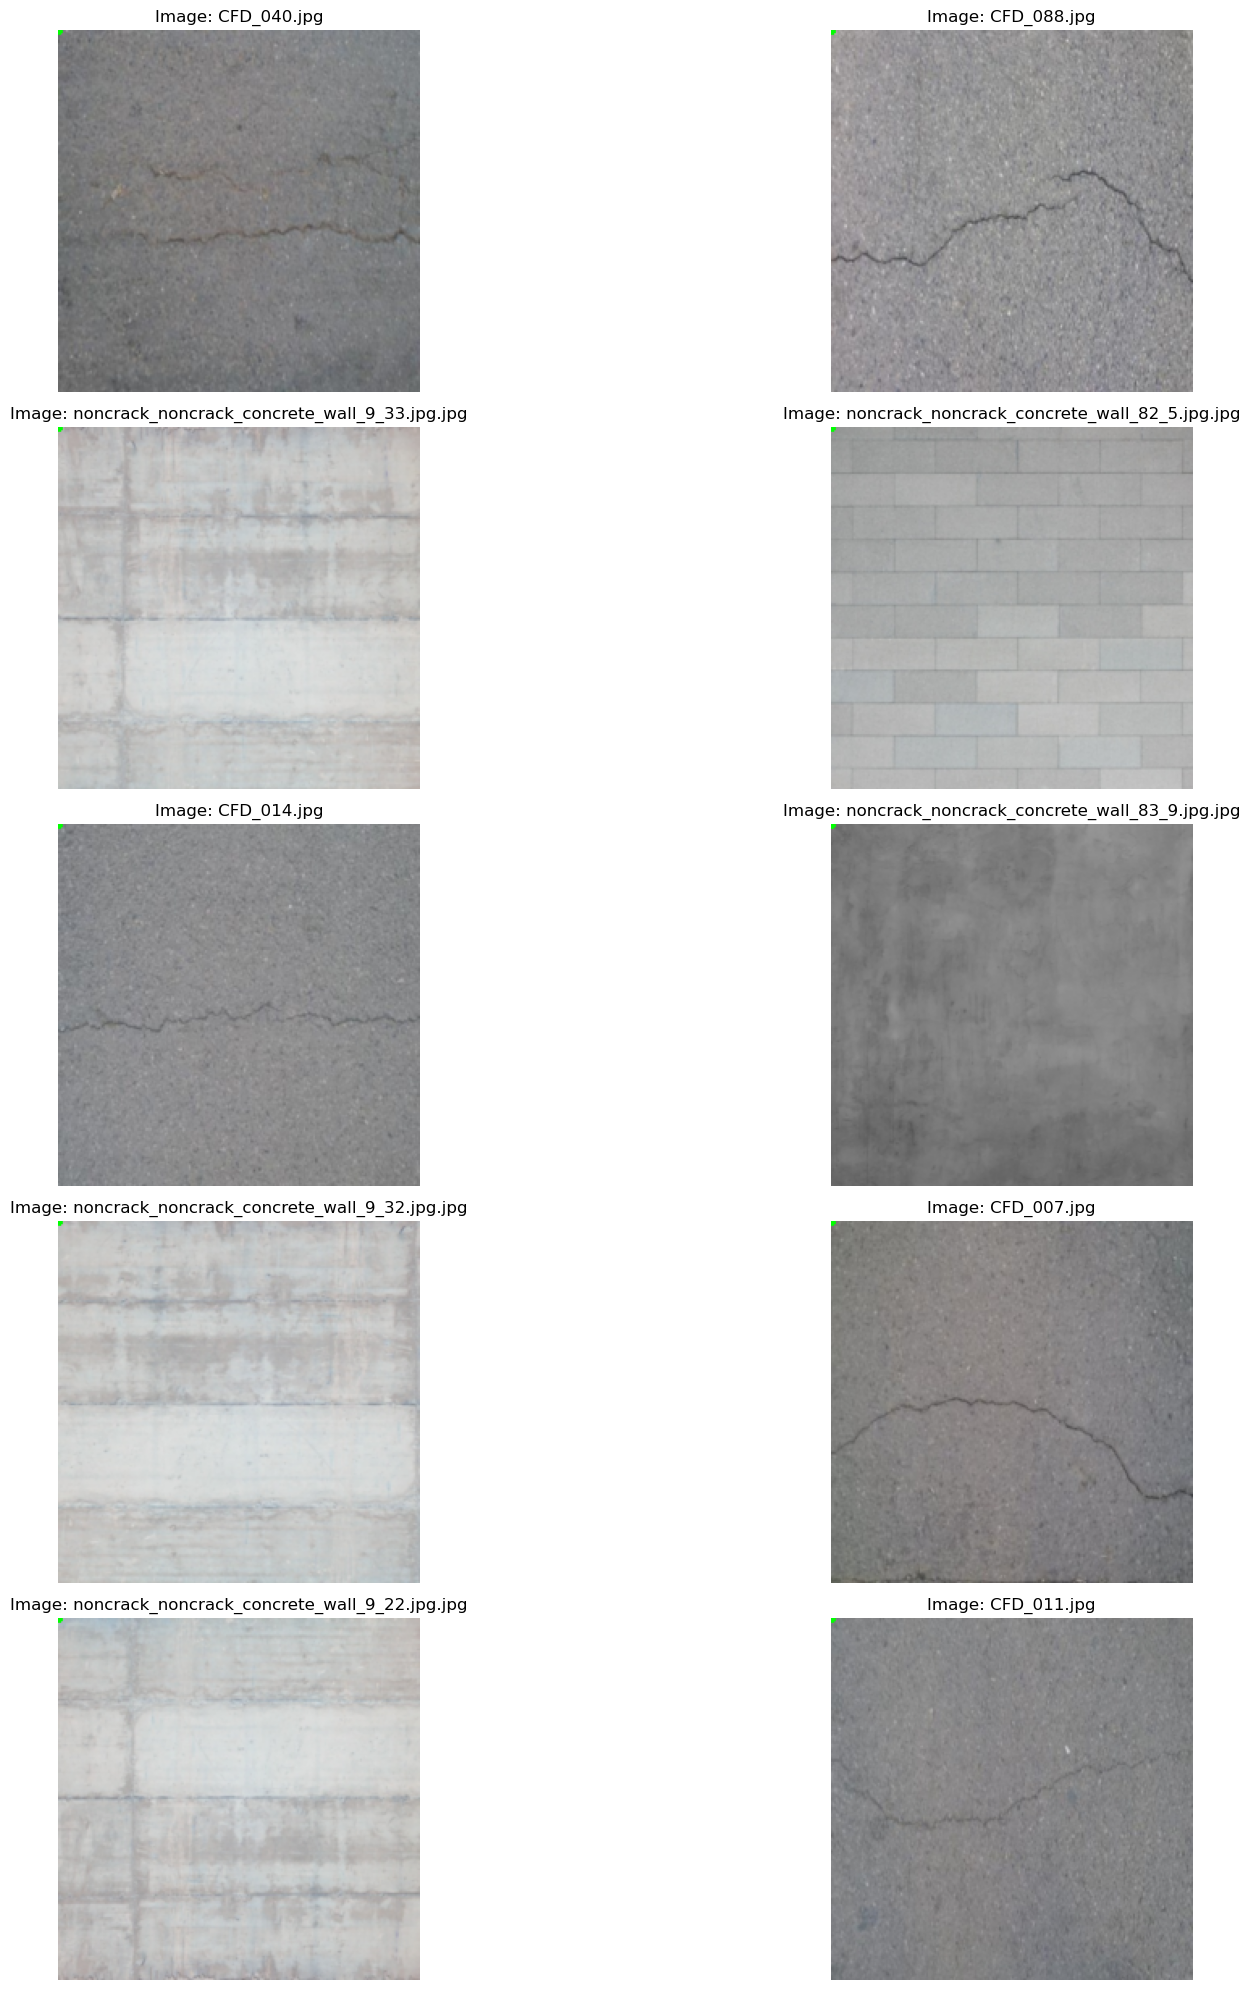

In [31]:
model = Resnext50RCNN()
checkpoint_path = os.path.join("checkpoints", f"rcnn_with_resnext_1.pt")

model.load_state_dict(torch.load(checkpoint_path))

model = model.to(device)

model.eval()

num_images_to_display = 10
random_indices = random.sample(range(len(valid_dataset)), num_images_to_display)
selected_images = [valid_dataset[idx] for idx in random_indices]
results = []

for image_path, image, _ in selected_images:
    prepared_image = image.cpu().permute(1, 2, 0).numpy()
    predictions = []
    all_proposals = []

    with torch.no_grad():
        for proposals in perform_selective_search(prepared_image, image_path=image_path):
            features = model.extract_region_features(image.to(device), proposals)
            class_scores, bbox_deltas = model.predict(features)
            refined_bboxes = model.refine_bboxes(proposals, bbox_deltas)
            high_score_indices = class_scores.squeeze() > 0
            refined_bboxes = refined_bboxes[high_score_indices]
    
            predictions.extend(refined_bboxes.cpu().numpy().tolist()[0])
            all_proposals.extend(proposals)
        
    results.append((image_path, image, predictions, all_proposals))

print([t[-2] for t in results])
plt.figure(figsize=(20, 20))

for i, (image_path, image, predictions, proposals) in enumerate(results):
    plt.subplot(5, 2, i + 1)

    image_with_boxes = image.permute(1, 2, 0).cpu().numpy().copy()

    for (x1, y1, x2, y2) in predictions:
        cv2.rectangle(image_with_boxes, (int(x1), int(y1)), (int(x2) + 1, int(y2) + 1), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
csc = class_scores.cpu().numpy()
bbd = bbox_deltas.cpu().numpy()